## How the news talks about Bitcoin

We will examine how The Guardian, a UK newsroom published articles about Bitcoin from 2020/05/01 to 2021/05/31 and how it will relate to Bitcoin prices.

We chose this period because May 2020 was just before the massive rise in Bitcoin prices and May 2021 was when the first massive drop in prices occurred.

Bitcoin is a virtual currency with a limited supply. You can treat it like a stock where its price depends on the demand.

## Querying The Guardian API

Use the [API](https://open-platform.theguardian.com/documentation/search) from The Guardian to get data.
- The content should mention the word `bitcoin`
- Data between 2020/05/01 to 2021/05/31
- We want all the associated metadata tags (the default does not return any).

Important, the free account has several limits:
- It limits 1 call per second (500 calls per day), use [`time.sleep()`](https://docs.python.org/3/library/time.html#time.sleep)
- It can only return a finite number of records per call, use instructions on [paging](https://open-platform.theguardian.com/documentation/).
- It limits to 10 results per page, adjust `page-size` parameter to the maximum value
- The total number of pages associated with any query is called `pages`.


In [ ]:
import requests
import time
url = 'https://content.guardianapis.com/search'
params = {
    'api-key': 'efbdc02b-5f06-42bf-9094-5b1e1aec4b06',
    'q': 'bitcoin',
    'show-tags': 'all',
    'from-date': '2020-05-01',
    'to-date': '2021-05-31',
    'page-size': 50
}
guardian = []
max_tags = 0

while True:
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print("Failed to retrieve data:", response.status_code)
        break

    data = response.json()
    results = data['response']['results']
    guardian.extend(results)

    # Update for max tags
    max_tags = max(max_tags, max(len(result['tags']) for result in results))

    current_page = data['response']['currentPage']
    total_pages = data['response']['pages']

    if current_page >= total_pages:
        break

    params['page'] = current_page + 1
    time.sleep(1)

In [ ]:
len_guardian = len(guardian)

In [ ]:
# Please report the number of records in guardian (Your answer should have between 200 and 250 data)
# Please report the maximum number of tags across all results
print("Number of records in guardian:", len_guardian)
print("Maximum number of tags across all results:", max_tags)

Number of records in guardian: 236
Maximum number of tags across all results: 37


In [ ]:
# file_path = ("/content/drive/MyDrive/Q0_backup_guardian.json")
# import json
# with open(file_path, 'r') as f:
#   dat = json.load(f)

## Wrangling data

To facilitate analysis later, wrangle the data in `guardian` into a pandas data frame, named `guardian_df`, where each row is a record from `guardian` with the following columns:
- `date`: Published date, e.g. "2021-05-01", this should be of the type `datetime`.
- `sectionName`: section name
- `pillarName`: pillar name
- `webTitle`: web title
- `{TAG_KEYWORD_WEBTITLE}`: these should be 0-1 columns indicating whether the corresponding tag is associated with this record.
  - replace `{TAG_KEYWORD_WEBTITLE}` with the wording of the actual `webTitle` of the tag.
  - only keep the tags where their `type` is `"keyword"`


In [ ]:
import pandas as pd
import numpy as np
guardian_df = pd.DataFrame(guardian)

In [ ]:
guardian_df.columns

Index(['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate',
       'webTitle', 'webUrl', 'apiUrl', 'tags', 'isHosted', 'pillarId',
       'pillarName'],
      dtype='object')

In [ ]:
#wrangling date
guardian_df['webPublicationDate'] = pd.to_datetime(guardian_df['webPublicationDate']).dt.date
guardian_df.rename(columns = {'webPublicationDate': 'date'}, inplace = True)

In [ ]:
guardian_df = guardian_df[['date', 'sectionName', 'pillarName', 'webTitle']]

In [ ]:
guardian_df.head()

,date,sectionName,pillarName,webTitle
0,2021-05-20,Technology,News,Bitcoin plunges after China crackdown
1,2021-04-13,World news,News,Turkey’s economic turmoil drives Bitcoin frenzy
2,2021-04-26,Life and style,Lifestyle,Can magic mushrooms really help you understand...
3,2021-05-19,Technology,News,Bitcoin: why the cryptocurrency is crashing af...
4,2021-05-28,Technology,News,Police find bitcoin mine using stolen electric...


In [ ]:
record = guardian[0]

In [ ]:
type(record)

dict

In [ ]:
record.keys()

dict_keys(['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate', 'webTitle', 'webUrl', 'apiUrl', 'tags', 'isHosted', 'pillarId', 'pillarName'])

In [ ]:
record_1 = record['tags']

In [ ]:
type(record_1)

list

In [ ]:
record_1[0]

{'id': 'technology/bitcoin',
 'type': 'keyword',
 'sectionId': 'technology',
 'sectionName': 'Technology',
 'webTitle': 'Bitcoin',
 'webUrl': 'https://www.theguardian.com/technology/bitcoin',
 'apiUrl': 'https://content.guardianapis.com/technology/bitcoin',
 'references': []}

In [ ]:
tag_columns = {}
for record in guardian:
    for tag in record['tags']:
        if tag['type'] == 'keyword':
            tag_keyword = tag['webTitle']
            tag_columns.setdefault(tag_keyword, []).append(1)
        else:
            tag_columns.setdefault(tag_keyword, []).append(0)

In [ ]:
tags_df = pd.DataFrame.from_dict(tag_columns, orient='index').T.fillna(0)
guardian_df = pd.concat([guardian_df, tags_df], axis=1)

In [ ]:
guardian_df.head(2)

,date,sectionName,pillarName,webTitle,Bitcoin,Cryptocurrencies,Technology,China,Elon Musk,World news,...,Infectious diseases,Melbourne,National party,Victorian politics,US elections 2020,Microbiology,Medical research,Scott Morrison,Josh Frydenberg,Anthony Albanese
0,2021-05-20,Technology,News,Bitcoin plunges after China crackdown,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2021-04-13,World news,News,Turkey’s economic turmoil drives Bitcoin frenzy,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Report the number of rows and columns in guardian_df using a print() statement.
print("Rows and columns in guardian_df:", guardian_df.shape[0])

Rows and columns in guardian_df: 236


In [ ]:
#Report the frequency of the different possible values in the pillarName column from guardian_df.
print("\nFrequency of different values in pillarName column:\n", guardian_df['pillarName'].value_counts())


Frequency of different values in pillarName column:
 News         190
Arts          20
Opinion       12
Lifestyle     10
Sport          4
Name: pillarName, dtype: int64


In [ ]:
#Report the 5 most popular keyword tag(s) used across all records.
print("\n5 most popular keyword tags:\n", tags_df.sum().sort_values(ascending=False).head(5))


5 most popular keyword tags:
 Business            125.0
Cryptocurrencies     74.0
Technology           73.0
Stock markets        67.0
Bitcoin              62.0
dtype: float64


## Getting the weekly bitcoin prices

In `btc_weekly_3months.csv` we have the weekly bitcoin prices over 3 months (we need it to match our news data) and `btc_daily_5years.csv` has the daily bitcoin prices over 5 years. Both datasets end in 2023.

- There is a single date value in the weekly records instead of a date range, what does this date correspond to in the week? Verify your claims using `assert` statements by checking your logic applied to daily is the same as in the weekly data. This assertion only needs to be demonstrated on one week.
  - In finance, "close" means the price at the end of the respective period. The "Adj" often refers to adjusted to seasonality.
  - In finance, "volume" means the number of units in the transaction.
- Produce the weekly data **over the 5 years** using the daily dataset for `Adj Close` and `Volume` according to the relationship we see.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
btc_weekly_3months = pd.read_csv('/content/drive/MyDrive/btc_weekly_3months.csv', usecols=['Date', 'Adj Close', 'Volume'])
btc_daily_5years = pd.read_csv('/content/drive/MyDrive/btc_daily_5years.csv', usecols=['Date', 'Adj Close', 'Volume'])

In [ ]:
btc_weekly_3months.head(2)

,Date,Adj Close,Volume
0,2023-09-04,25832.226563,69814611152
1,2023-09-11,26534.187500,85796699860


In [ ]:
btc_daily_5years.head(2)

,Date,Adj Close,Volume
0,2018-12-03,3894.130859,5089570994
1,2018-12-04,3956.893799,5028069239


In [ ]:
#change to date time
btc_weekly_3months['Date'] = pd.to_datetime(btc_weekly_3months['Date'])
btc_daily_5years['Date'] = pd.to_datetime(btc_daily_5years['Date'])

In [ ]:
# Verify the relationship between weekly and daily values
from datetime import timedelta
sample_week_date = btc_weekly_3months['Date'].iloc[0]
start_date = sample_week_date - pd.DateOffset(days=6)
end_date = sample_week_date

In [ ]:
sample_week_daily = btc_daily_5years[(btc_daily_5years['Date'] >= start_date) & (btc_daily_5years['Date'] <= end_date)]

we assume that there should be some relationships between them, i.e. The "Adj Close", "Volume" for the weekly data should be the same as the "Adj Close", "Volume" on the last day of the week

In [ ]:
assert btc_weekly_3months[btc_weekly_3months['Date'] == sample_week_date]['Adj Close'].iloc[0] == sample_week_daily.iloc[-1]['Adj Close']

AssertionError: ignored

In [ ]:
assert btc_weekly_3months[btc_weekly_3months['Date'] == sample_week_date]['Volume'].iloc[0] == sample_week_daily['Volume'].sum()

AssertionError: ignored

In [ ]:
sample_week_daily.iloc[-1]

Date           2023-09-04 00:00:00
Adj Close             25812.416016
Volume                 10680635106
Week_Ending    2023-09-10 00:00:00
Name: 1736, dtype: object

In [ ]:
btc_weekly_3months[btc_weekly_3months['Date'] == sample_week_date]

,Date,Adj Close,Volume
0,2023-09-04,25832.226563,69814611152


In [ ]:
btc_weekly_3months[btc_weekly_3months['Date'] == sample_week_date]['Volume'].iloc[0]

69814611152

In [ ]:
sample_week_daily['Volume'].sum()

112839457721

Therefore, by assertion error, they are not the same, but the adj close values are close to each other. On the other hand, for the volume, the value for volumes are far away from each other.

In [ ]:
btc_daily_5years['Week_Ending'] = btc_daily_5years['Date'].apply(lambda x: x + timedelta(days=(6 - x.weekday())))
btc_weekly = btc_daily_5years.groupby('Week_Ending').agg({'Adj Close': 'last', 'Volume': 'sum'}).reset_index()
btc_weekly.rename(columns={'Week_Ending': 'Date'}, inplace=True)

In [ ]:
#Please print out the first 3 and last 3 weeks of data in btc_weekly, after sorting by Date.
btc_weekly = btc_weekly.sort_values(by='Date')
print(btc_weekly.head(3))
print(btc_weekly.tail(3))

        Date    Adj Close       Volume
0 2018-12-09  3614.234375  38386467708
1 2018-12-16  3252.839111  29869247431
2 2018-12-23  3998.980225  46021506218
          Date     Adj Close        Volume
257 2023-11-12  37054.519531  134767494805
258 2023-11-19  37386.546875  143535361089
259 2023-11-26  37479.121094  130439893957


In [ ]:
#Please print out the number of rows and columns in the dataset.
print("Number of rows and columns:", btc_weekly.shape)

Number of rows and columns: (260, 3)


In [ ]:
btc_weekly.head()

,Date,Adj Close,Volume
0,2018-12-09,3614.234375,38386467708
1,2018-12-16,3252.839111,29869247431
2,2018-12-23,3998.980225,46021506218
3,2018-12-30,3865.952637,39249734918
4,2019-01-06,4076.632568,34343716582


## Exploring the data

- Using `btc_weekly`, plot the two time-series curves `Adj Close` and `Volume` over the 5 years on a comparable axis in the same plot.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

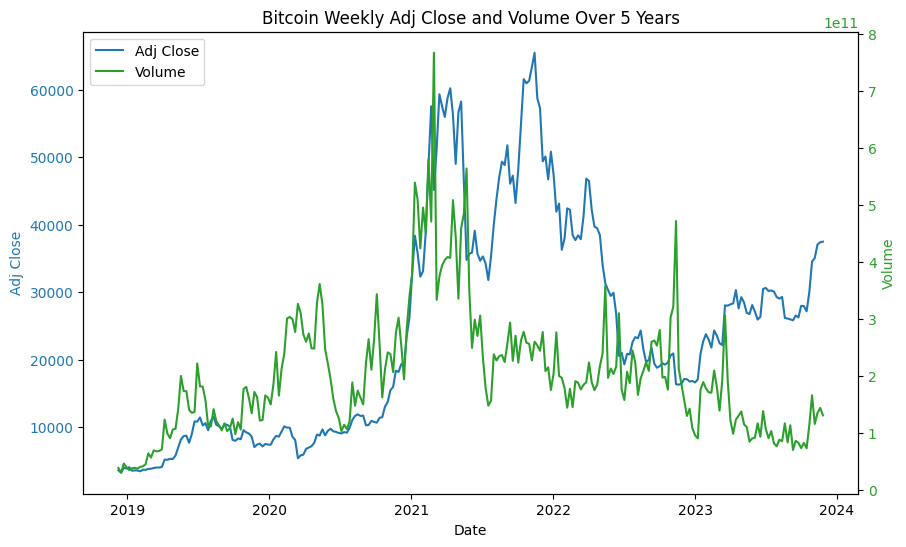

In [ ]:
import matplotlib.pyplot as plt

btc_weekly['Date'] = pd.to_datetime(btc_weekly['Date'])

# Plotting with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Adj Close', color=color)
adj_close_line, = ax1.plot(btc_weekly['Date'], btc_weekly['Adj Close'], color=color, label='Adj Close')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Volume', color=color)
volume_line, = ax2.plot(btc_weekly['Date'], btc_weekly['Volume'], color=color, label='Volume')
ax2.tick_params(axis='y', labelcolor=color)

# Adding the legend
plt.legend(handles=[adj_close_line, volume_line], loc='upper left')

plt.title('Bitcoin Weekly Adj Close and Volume Over 5 Years')
plt.show()


## feature creation

In the **next problem**, we want to model the relationship between different keywords and the rise/fall of bitcoin prices. This is preparing our datasets for the next question.

- First, add 2 additional columns to `guardian_df` by using **a single regular expression** for each:
  - `positive_title`: this is 1 if one of the `good_words` (see below) are in the `webTitle`. 0 otherwise.
  - `negative_title`: this is 1 if one of the `bad_words` (see below) are in the `webTitle`. 0 otherwise.

```
bad_words = ["plung", "crash", "drop", "tumble", "retreat", "low", "lose", "slide", "fizzle", "sell", "fear"]
good_words = ["buy", "rebound", "climb", "rise", "boom", "buy", "high", "surge", "jump", "soar", "grow"]
```

In [ ]:
guardian_df.head(2)

,date,sectionName,pillarName,webTitle,Bitcoin,Cryptocurrencies,Technology,China,Elon Musk,World news,...,Infectious diseases,Melbourne,National party,Victorian politics,US elections 2020,Microbiology,Medical research,Scott Morrison,Josh Frydenberg,Anthony Albanese
0,2021-05-20,Technology,News,Bitcoin plunges after China crackdown,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2021-04-13,World news,News,Turkey’s economic turmoil drives Bitcoin frenzy,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import re

In [ ]:
bad_words = ["plung", "crash", "drop", "tumble", "retreat", "low", "lose", "slide", "fizzle", "sell", "fear"]
good_words = ["buy", "rebound", "climb", "rise", "boom", "buy", "high", "surge", "jump", "soar", "grow"]

In [ ]:
bad_words_regex = re.compile('|'.join(bad_words), re.IGNORECASE)
good_words_regex = re.compile('|'.join(good_words), re.IGNORECASE)

In [ ]:
def contains_word(s, pattern):
    return 1 if pattern.search(s) else 0

In [ ]:
guardian_df['positive_title'] = guardian_df['webTitle'].apply(lambda x: contains_word(x, good_words_regex))
guardian_df['negative_title'] = guardian_df['webTitle'].apply(lambda x: contains_word(x, bad_words_regex))

In [ ]:
guardian_df.shape

(236, 373)

In [ ]:
#Please print out the total number of positive and negative titles across all records.
total_positive = guardian_df['positive_title'].sum()
total_negative = guardian_df['negative_title'].sum()
both_positive_and_negative = guardian_df[(guardian_df['positive_title'] == 1) & (guardian_df['negative_title'] == 1)].shape[0]

print("Total number of positive titles:", total_positive)
print("Total number of negative titles:", total_negative)

Total number of positive titles: 64
Total number of negative titles: 36


In [ ]:
#Please report the number of titles that are both positive and negative.
print("Number of titles that are both positive and negative:", both_positive_and_negative)

Number of titles that are both positive and negative: 12


## Feature creation part 2

- Calculate the frequency for each of the keyword columns and the 2 new columns for each week (the week definition should be the same as `btc_weekly`). These frequencies should be stored in a data frame named `X`.
  - The columns of `X` should be all the keywords from the tags plus `positive_title` and `negative_title`.
  - For incomplete weeks, assume those days have 0 occurrences for all features. If a week is completely missing, we do not need to create a record for it.

- Please sort the columns in `X` according to their total frequency across all weeks. So the first column should be the most popular (i.e. most articles include this keyword) feature and the last column should be the least popular. Call this variable `X_ord`.
  - Ties can be in any order.



In [ ]:
tags_df.head(2)

,Bitcoin,Cryptocurrencies,Technology,China,Elon Musk,World news,Turkey,E-commerce,Economics,Global economy,...,Infectious diseases,Melbourne,National party,Victorian politics,US elections 2020,Microbiology,Medical research,Scott Morrison,Josh Frydenberg,Anthony Albanese
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def get_following_sunday(date):
    days_until_sunday = 6 - date.weekday()
    sunday_date = date + timedelta(days=days_until_sunday)
    return sunday_date

In [ ]:
guardian_df['week_ending'] = guardian_df['date'].apply(get_following_sunday)

In [ ]:
X = guardian_df.groupby('week_ending').sum()

In [ ]:
X.head()

,Bitcoin,Cryptocurrencies,Technology,China,Elon Musk,World news,Turkey,E-commerce,Economics,Global economy,...,National party,Victorian politics,US elections 2020,Microbiology,Medical research,Scott Morrison,Josh Frydenberg,Anthony Albanese,positive_title,negative_title
week_ending,,,,,,,,,,,,,,,,,,,,,
2020-05-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2020-05-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2020-06-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2020-06-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2020-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
X_ord = X.reindex(X.sum().sort_values(ascending=False).index, axis=1)

In [ ]:
X_ord.head(2)

,Business,Cryptocurrencies,Technology,Stock markets,positive_title,Bitcoin,Economics,World news,UK news,FTSE,...,Rolls-Royce,BAE Systems,Serious Fraud Office,Cineworld,Carbon capture and storage (CCS),Greenhouse gas emissions,Conservation,Climate science,Biodiversity,Insurance industry
week_ending,,,,,,,,,,,,,,,,,,,,,
2020-05-03,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-10,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Please print out the data for the last 2 weeks for X_ord along with the features (column names) they correspond to.
print(X_ord.tail(2))
print("\nFeatures (column names):")
print(X_ord.columns.tolist())

             Business  Cryptocurrencies  Technology  Stock markets  \
week_ending                                                          
2021-05-23       16.0               9.0        10.0           13.0   
2021-05-30        4.0               3.0         3.0            4.0   

             positive_title  Bitcoin  Economics  World news  UK news  FTSE  \
week_ending                                                                  
2021-05-23                2      9.0        7.0         9.0      5.0   9.0   
2021-05-30                4      3.0        1.0         2.0      1.0   2.0   

             ...  Rolls-Royce  BAE Systems  Serious Fraud Office  Cineworld  \
week_ending  ...                                                              
2021-05-23   ...          1.0          1.0                   1.0        1.0   
2021-05-30   ...          0.0          0.0                   0.0        0.0   

             Carbon capture and storage (CCS)  Greenhouse gas emissions  \
week_ending   

## SQL
In the file `final2023.db`, we have the data similar to `guardian_df` in a table called `guardian`.

Write the SQL query into the variable `query` that would compute the fraction of articles with positive titles (see Q4) for each possible type of `pillarName`, e.g. Arts, News, etc.
- Our query should return the pillarName AND the respective fraction.
- use `sqlite3` and SQL to complete this question
- The column names of the table are the same as the columns in `guardian_df`.


In [ ]:
guardian_df.head(2)

,date,sectionName,pillarName,webTitle,Bitcoin,Cryptocurrencies,Technology,China,Elon Musk,World news,...,Victorian politics,US elections 2020,Microbiology,Medical research,Scott Morrison,Josh Frydenberg,Anthony Albanese,positive_title,negative_title,week_ending
0,2021-05-20,Technology,News,Bitcoin plunges after China crackdown,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,2021-05-23
1,2021-04-13,World news,News,Turkey’s economic turmoil drives Bitcoin frenzy,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2021-04-18


In [ ]:
import sqlite3

connection = sqlite3.connect('/content/drive/MyDrive/final2023.db')

query = """
SELECT pillarName,
       SUM(CASE WHEN positive_title = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS positive_title_fraction
FROM guardian
GROUP BY pillarName;

"""

cursor = connection.cursor()
print(cursor.execute(query).fetchall())
connection.close()

[('Arts', 0.0), ('Lifestyle', 0.5), ('News', 0.3157894736842105), ('Opinion', 0.0), ('Sport', 0.0)]


## Modeling

Using `X_ord` and `btc_weekly`, we will predict the `Adj Close` by the frequency of the `p` most popular keywords (recall what `ord` means in `X_ord`) in respective weeks.

- Make sure you're only using weeks that are entirely in the range of `2020-05-01` to `2021-05-31`.
  -`2020-05-04` and `2021-05-31` are both Mondays.
- What value of `p` will minimize a 5-fold cross-validated RMSE?
  - limit `p` to values below `20`.
  - set the `random_state` to the value `5206` when constituting K-fold cross-validation sets.
  - We will compare 20 models, and the $i$-th model uses the first $i$ features in `X_ord`.


In [ ]:
X_ord.head(2)

,Business,Cryptocurrencies,Technology,Stock markets,positive_title,Bitcoin,Economics,World news,UK news,FTSE,...,Rolls-Royce,BAE Systems,Serious Fraud Office,Cineworld,Carbon capture and storage (CCS),Greenhouse gas emissions,Conservation,Climate science,Biodiversity,Insurance industry
week_ending,,,,,,,,,,,,,,,,,,,,,
2020-05-03,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-10,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
btc_weekly.head(2)

,Date,Adj Close,Volume
0,2018-12-09,3614.234375,38386467708
1,2018-12-16,3252.839111,29869247431


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
btc_weekly['Date'] = pd.to_datetime(btc_weekly['Date'])

In [ ]:
X_ord.reset_index(inplace=True)
X_ord['week_ending'] = pd.to_datetime(X_ord['week_ending'])

In [ ]:
merged_df = pd.merge(btc_weekly, X_ord, left_on='Date', right_on = 'week_ending', how = 'inner')

In [ ]:
#filter for date range
start_date = '2020-05-04'
end_date = '2021-05-31'
filtered_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]

In [ ]:
X = filtered_df[X_ord.columns]  # Features
y = filtered_df['Adj Close']    # Target variable
X = X.drop(columns=['Date'], errors='ignore')

In [ ]:
for col in X.columns:
    if pd.api.types.is_datetime64_any_dtype(X[col]):
        X[col] = X[col].apply(lambda x: x.timestamp())

In [ ]:
len(X)

42

In [ ]:
len(y)

42

In [ ]:
best_p = 0
best_rmse = float('inf')

In [ ]:
for p in range(1, min(21, X.shape[1] + 1)):
    model = LinearRegression()
    X_p = X.iloc[:, :p]
    kf = KFold(n_splits=5, shuffle=True, random_state=5206)

    mse = cross_val_score(model, X_p, y, cv=kf, scoring='neg_mean_squared_error', error_score='raise')
    rmse = np.sqrt(-mse).mean()

    if rmse < best_rmse:
        best_rmse = rmse
        best_p = p

In [ ]:
best_model = LinearRegression().fit(X.iloc[:, :best_p], y)

In [ ]:
print(f"Best p: {best_p}")
print(f"Coefficients of the best model: {best_model.coef_}")

Best p: 7
Coefficients of the best model: [ 1.06446397e+03  1.06446397e+03 -8.98321644e-04 -1.14743980e+02
  3.57567070e+03  1.28121872e+03 -4.94068751e+03]
